<h1 style="text-align: center; color: #6A5ACD;">
Más Allá de la Predicción: Simulaciones para Entender el Abandono en Salud Mental
</h1>

<h2 style="color: #6A5ACD;">
Creación de churn y Cohortes descriptivas
</h2>

<h2 style="color: #6A5ACD;">
1. Configuración y librerías necesarias
</h2>

In [2]:
# Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import chi2_contingency
import os


# Configuración general
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


# Carpetas de salida
os.makedirs("out", exist_ok=True)
os.makedirs("fig", exist_ok=True)

# Función utilitaria para guardar figuras
def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show()


<h2 style="color: #6A5ACD;">
2. Carga de datos
</h2>

In [3]:
DATA_PATH = "data/mental_health_data final data.csv"  
df = pd.read_csv(DATA_PATH)

# Resumen inicial
n_rows, n_cols = df.shape
print(f"Registros: {n_rows:,} | Columnas: {n_cols}")
display(df.head(3))
display(df.info())

Registros: 50,000 | Columnas: 17


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 24998 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  object 
 9   Sleep_Hours              50000 non-null  float64
 10  Work_Hours               50000 non-null  int64  
 11  Physical_Activity_Hours  50000 non-null  int64  
 12  Social_Media_Usage       50000 non-null  float64
 13  Diet_Quality             50000 non-null  object 
 14  Smoking_Habit         

None

<h2 style="color: #6A5ACD;">
3. Definición de Variable Target
</h2>



Para los fines de este estudio, se define la variable *churn* como la situación en la que una persona **ha sido diagnosticada con una condición de salud mental** (`Mental_Health_Condition = Yes`) pero **no ha tenido consultas médicas registradas** (`Consultation_History = No`). En este caso, `churn = 1`. El resto de los individuos se codifican como `churn = 0`.


In [4]:
# churn = 1 si tiene diagnóstico de salud mental pero nunca consultó
df["churn"] = ((df["Mental_Health_Condition"] == "Yes") & 
               (df["Consultation_History"] == "No")).astype(int)

target_col = "churn"

,churn,count,pct
0,0,37440,74.88
1,1,12560,25.12


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3961085965.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="churn", y="count", data=conteo, palette="Set2")


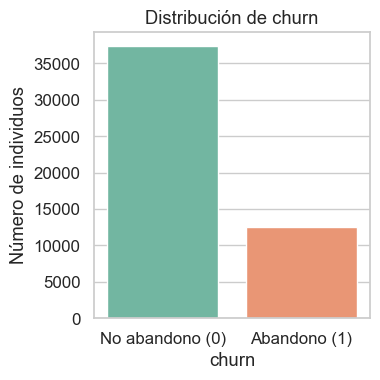

In [5]:
# Validar distribución de churn
conteo = df[target_col].value_counts().rename_axis("churn").reset_index(name="count")
conteo["pct"] = 100 * conteo["count"] / len(df)
display(conteo)

# Visualización de la distribución
plt.figure(figsize=(4,4))
sns.barplot(x="churn", y="count", data=conteo, palette="Set2")
plt.xticks([0,1], ["No abandono (0)", "Abandono (1)"])
plt.ylabel("Número de individuos")
plt.title("Distribución de churn")
savefig("fig/churn_distribution.png")

La variable objetivo `churn` muestra que aproximadamente **1 de cada 4 individuos (25.1%)** se encuentra en situación de abandono: es decir, cuentan con un diagnóstico de salud mental pero no han realizado consultas médicas. En contraste, la gran mayoría (74.9%) no presenta esta condición de abandono.

Este resultado es relevante desde distintas perspectivas:

- Indica que existe un segmento considerable de la población con necesidades reconocidas de salud mental que permanece desconectado del sistema de atención. Este patrón puede estar relacionado con barreras de acceso, estigma social o desigualdades estructurales en el cuidado de la salud.

- La proporción de casos `churn = 1` (25%) es suficientemente amplia como para permitir comparaciones entre grupos y aplicar modelos explicativos sin problemas graves de desbalance de clases.

- Disponer de una variable objetivo con una distribución clara (75% vs. 25%) facilita tanto los análisis descriptivos de cohortes como la futura estimación de modelos logísticos. Esto permite identificar factores diferenciales que aumentan o disminuyen la probabilidad de abandono.

En resumen, la distribución observada justifica el uso de `churn` como variable clave para segmentar la población y analizar perfiles de riesgo.


<h2 style="color: #6A5ACD;">
4. Análisis de la Tasa Global de Churn y su Precisión Estadística (IC 95%)<
</h2>

In [6]:
# Función para calcular el intervalo de confianza de Wilson
def wilson_ci(successes, n, alpha=0.05):
    ci_low, ci_high = proportion_confint(successes, n, alpha=alpha, method="wilson")
    return ci_low, ci_high

tasa_global = df[target_col].mean()
ci_low, ci_high = wilson_ci(df[target_col].sum(), df[target_col].notna().sum())

print(f"Tasa global de churn: {tasa_global:.2%} (IC95%: {ci_low:.2%} – {ci_high:.2%})")

Tasa global de churn: 25.12% (IC95%: 24.74% – 25.50%)


- Vemos que la Tasa global de churn = 25.12%, lo que significa que, en el dataset, 1 de cada 4 individuos diagnosticados con una condición de salud mental no ha tenido consultas registradas, y por lo tanto se consideran en situación de abandono.

- El intervalo de confianza de Wilson (IC95%: 24.74% – 25.50%) nos da un rango de valores plausibles para la tasa real de churn en la población, con un 95% de confianza estadística.Es decir, si repitiésemos este estudio en múltiples muestras de la misma población, el 95% de esos intervalos construidos contendrían la tasa verdadera de abandono.

- En este caso, el IC es muy estrecho (solo ±0.38%), lo que ocurre porque tenemos un tamaño muestral grande (n=50,000) lo que reduce la incertidumbre. La proporción está bien definida (~25%),  alejada de los extremos 0% o 100%.

- La tasa global de abandono (churn) se estima en un **25.1%**, lo que implica que aproximadamente uno de cada cuatro pacientes diagnosticados con una condición de salud mental no mantiene consultas médicas. El intervalo de confianza del 95% (24.7% – 25.5%) confirma que esta estimación es estadísticamente precisa, debido al gran tamaño muestral. En términos prácticos, esto evidencia un segmento poblacional relevante en situación de abandono, cuya caracterización es clave para los análisis posteriores de cohortes y perfiles de riesgo.

<h2 style="color: #6A5ACD;">
5. Cohortes descriptivas
</h2>

De acuerdo con los hallazgos del **EDA inicial (Notebook 0)**, se tomaron las siguientes decisiones metodológicas para garantizar coherencia y robustez en el análisis:

1. **Valores nulos**  
   - La variable `Severity` presentaba ~50% de valores ausentes.  
   - En lugar de eliminar casos, se creó una categoría explícita `Unknown` para mantener el tamaño muestral y analizar este grupo como un perfil de riesgo separado.

2. **Outliers**  
   - Con el criterio clásico de IQR no se detectaron valores atípicos en las variables numéricas (`Age`, `Sleep_Hours`, `Work_Hours`, `Physical_Activity_Hours`, `Social_Media_Usage`).  
   - Por ello, no fue necesario excluir ni transformar observaciones extremas.

3. **Normalidad de variables numéricas**  
   - Las pruebas de D’Agostino K² rechazaron normalidad en todas las variables numéricas (p ≈ 0).  
   - Esto justificó el uso de **discretización en intervalos (binning)** para facilitar la construcción de cohortes y la aplicación de pruebas no paramétricas.

4. **Construcción de cohortes**  
   - Se agruparon las variables numéricas en intervalos teóricamente relevantes:  
     - `Age_group` → (18–29, 30–44, 45–59, 60+).  
     - `Sleep_group` → (<5h, 5–7h, 7–9h, >9h).  
     - `Work_group` → (≤40h, 41–55h, 56–70h, >70h).  
     - `PA_group` → (<2h, 2–5h, 5–8h, >8h).  
     - `SM_group` → (≤1h, 1–3h, 3–5h, >5h).  

In [7]:
# Binning para cohortes 
df["Age_group"] = pd.cut(df["Age"], bins=[17,29,44,59,80],
                         labels=["18-29","30-44","45-59","60+"], include_lowest=True)

def bin_hours(s, bins, labels):
    return pd.cut(s, bins=bins, labels=labels, include_lowest=True)

df["Sleep_group"] = bin_hours(df["Sleep_Hours"], [0,5,7,9,24], ["<5h","5-7h","7-9h",">9h"])
df["Work_group"]  = bin_hours(df["Work_Hours"],  [0,40,55,70,200], ["≤40","41-55","56-70",">70"])
df["PA_group"]    = bin_hours(df["Physical_Activity_Hours"], [0,2,5,8,100], ["<2h","2-5h","5-8h",">8h"])
df["SM_group"]    = bin_hours(df["Social_Media_Usage"], [0,1,3,5,100], ["≤1h","1-3h","3-5h",">5h"])

# Severidad con 'Unknown' 
df["Severity_filled"] = df["Severity"].fillna("Unknown").astype("category")

# Scores derivados para el modelo (se usarán en el Notebook 2) 
df["work_sleep_ratio"] = df["Work_Hours"] / (df["Sleep_Hours"] * 7)
df["lifestyle_risk"] = (
    (df["Smoking_Habit"]=="Current").astype(int)
  + (df["Alcohol_Consumption"].isin(["High","Very High"])).astype(int)
  + (df["Diet_Quality"]=="Unhealthy").astype(int)
  + (df["Physical_Activity_Hours"]<2).astype(int)
)

# Cohortes a reportar ahora (descriptivo) 
cortes = ["Age_group","Gender","Country","Stress_Level","Severity_filled",
          "Sleep_group","Work_group","PA_group","SM_group"]
cortes = [c for c in cortes if c in df.columns]

def wilson_ci(k,n): 
    lo, hi = proportion_confint(k, n, method="wilson"); return lo, hi

def tasa_por_grupo(df, col, target="churn"):
    g = (df.groupby(col)[target].agg(['count','sum','mean'])
           .rename(columns={'count':'n','sum':'churn_1','mean':'rate'}).reset_index())
    cis = g.apply(lambda r: pd.Series(wilson_ci(r['churn_1'], r['n']), index=['ci_low','ci_high']), axis=1)
    g = pd.concat([g, cis], axis=1).sort_values('rate', ascending=False)
    return g

for c in cortes:
    tbl = tasa_por_grupo(df, c)
    display(tbl)
    tbl.to_csv(f"out/churn_by_{c}.csv", index=False)


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,Age_group,n,churn_1,rate,ci_low,ci_high
0,18-29,12535,3198,0.255126,0.247570,0.262831
1,30-44,15680,3930,0.250638,0.243916,0.257482
2,45-59,15525,3877,0.249726,0.242980,0.256596
3,60+,6260,1555,0.248403,0.237855,0.259258


,Gender,n,churn_1,rate,ci_low,ci_high
3,Prefer not to say,12558,3186,0.253703,0.246169,0.261388
0,Female,12633,3204,0.253621,0.246110,0.261283
2,Non-binary,12336,3096,0.250973,0.243400,0.258701
1,Male,12473,3074,0.246452,0.238968,0.254092


,Country,n,churn_1,rate,ci_low,ci_high
4,Other,7124,1810,0.254071,0.244096,0.264311
5,UK,6963,1760,0.252765,0.242695,0.263107
2,Germany,7156,1807,0.252515,0.242584,0.262712
6,USA,7271,1825,0.250997,0.241164,0.261093
0,Australia,7014,1758,0.250642,0.240638,0.260919
1,Canada,7149,1782,0.249266,0.239374,0.259426
3,India,7323,1818,0.248259,0.238498,0.258284


,Stress_Level,n,churn_1,rate,ci_low,ci_high
0,High,16707,4274,0.255821,0.249261,0.262493
1,Low,16446,4121,0.250578,0.244013,0.257258
2,Medium,16847,4165,0.247225,0.240769,0.253796


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,Severity_filled,n,churn_1,rate,ci_low,ci_high
3,Unknown,25002,6308,0.252300,0.246954,0.257721
1,Low,8261,2068,0.250333,0.241109,0.259789
2,Medium,8436,2111,0.250237,0.241109,0.259592
0,High,8301,2073,0.249729,0.240535,0.259155


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,Sleep_group,n,churn_1,rate,ci_low,ci_high
0,<5h,8656,2217,0.256123,0.247037,0.265425
2,7-9h,16614,4234,0.254845,0.248276,0.261528
3,>9h,8061,2053,0.254683,0.245290,0.264309
1,5-7h,16669,4056,0.243326,0.236872,0.249899


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,Work_group,n,churn_1,rate,ci_low,ci_high
2,56-70,14692,3714,0.252791,0.245828,0.259882
1,41-55,14822,3741,0.252395,0.245467,0.259452
0,≤40,10632,2676,0.251693,0.243534,0.260031
3,>70,9854,2429,0.246499,0.238090,0.255106


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,PA_group,n,churn_1,rate,ci_low,ci_high
2,5-8h,13590,3474,0.255629,0.248365,0.263031
0,<2h,13775,3479,0.252559,0.245373,0.259883
3,>8h,9004,2236,0.248334,0.239519,0.257364
1,2-5h,13631,3371,0.247304,0.240133,0.254617


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\2604375210.py:34: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (df.groupby(col)[target].agg(['count','sum','mean'])


,SM_group,n,churn_1,rate,ci_low,ci_high
0,≤1h,5022,1275,0.253883,0.242037,0.266105
1,1-3h,18235,4627,0.253743,0.247479,0.260110
2,3-5h,18231,4545,0.249301,0.243074,0.255633
3,>5h,8512,2113,0.248238,0.239176,0.257527


<h2 style="color: #6A5ACD;">
6. Tasas de Churn por Cohorte con Intervalos de Confianza del 95%
</h2>

C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


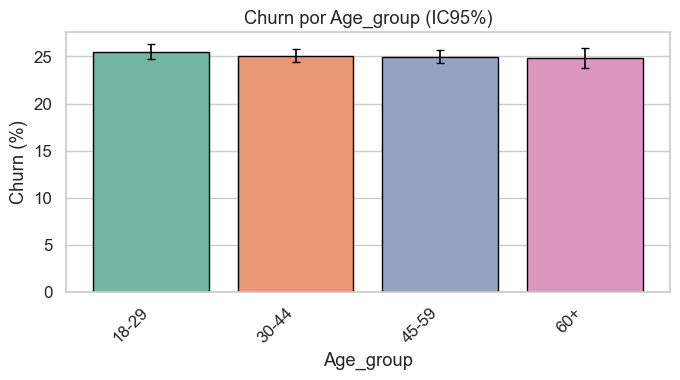

Guardado: fig/churn_by_Age_group_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


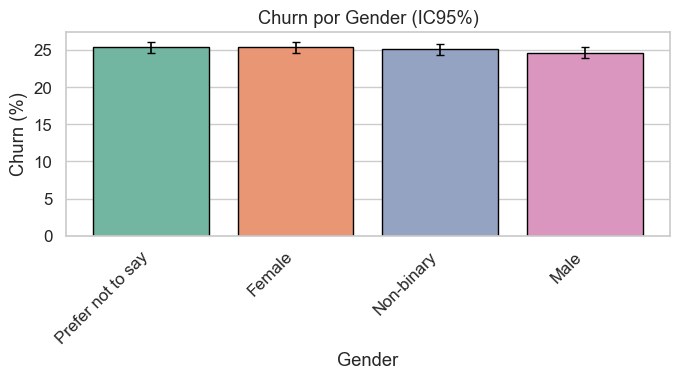

Guardado: fig/churn_by_Gender_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


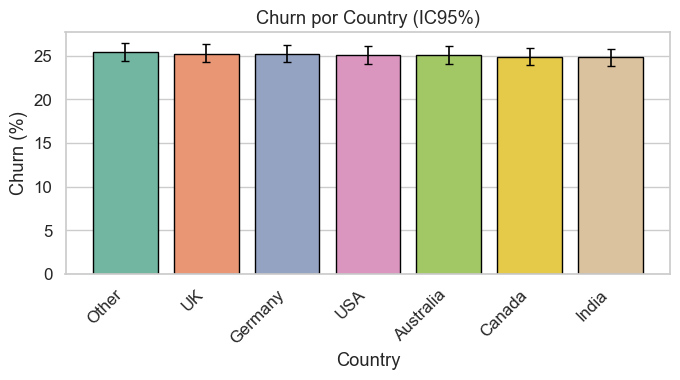

Guardado: fig/churn_by_Country_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


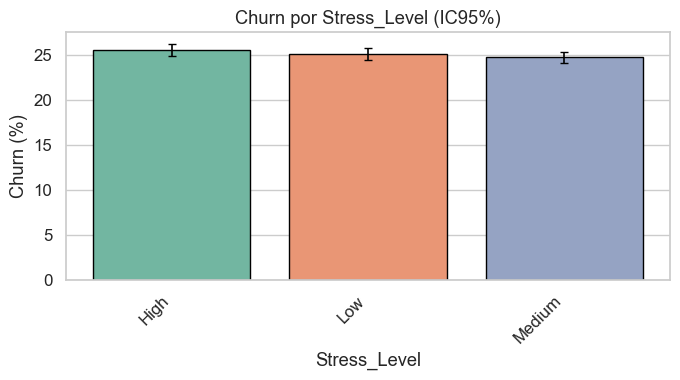

Guardado: fig/churn_by_Stress_Level_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


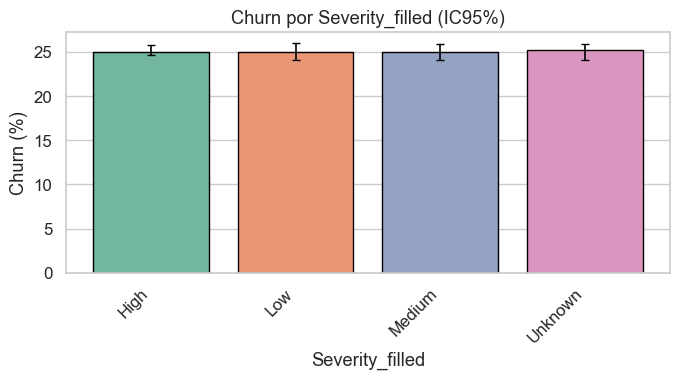

Guardado: fig/churn_by_Severity_filled_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


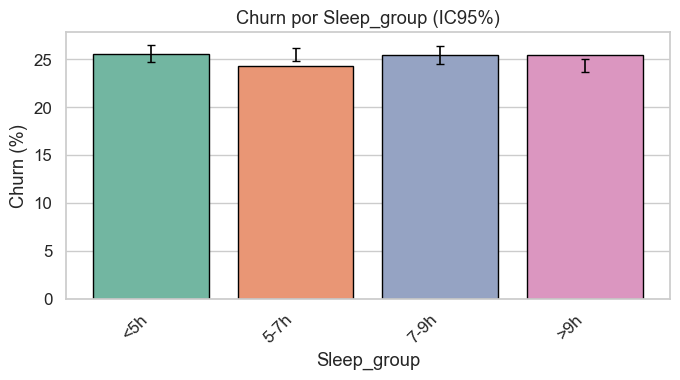

Guardado: fig/churn_by_Sleep_group_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


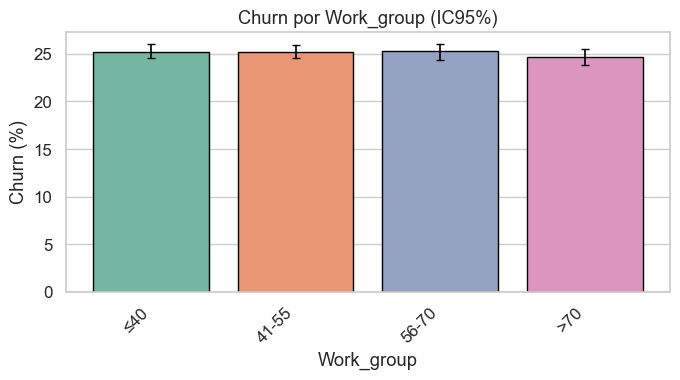

Guardado: fig/churn_by_Work_group_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


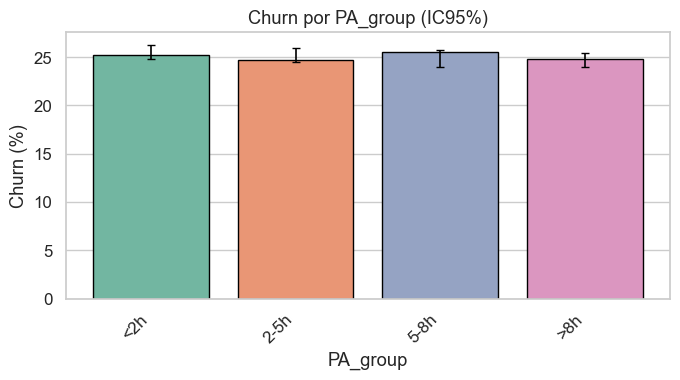

Guardado: fig/churn_by_PA_group_ci.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(col)[target]
C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\3664666435.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")


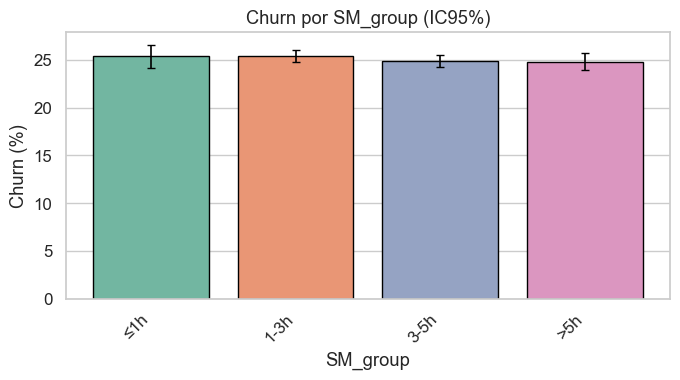

Guardado: fig/churn_by_SM_group_ci.png


In [8]:

# Barplots de churn con IC95% por cohorte
def wilson_ci(k, n, alpha=0.05):
    lo, hi = proportion_confint(k, n, alpha=alpha, method="wilson")
    return lo, hi

def plot_cohort_with_ci(tbl, var_name, fname):
    """
    Espera una tabla con columnas: [var_name, n, churn_1, rate, ci_low, ci_high]
    Crea un barplot con barras de error (IC95%) y guarda en fig/.
    """
    # Orden por tasa
    tbl = tbl.sort_values("rate", ascending=False).reset_index(drop=True)
    # Error bars en puntos porcentuales
    err_low = (tbl["rate"] - tbl["ci_low"]) * 100
    err_high = (tbl["ci_high"] - tbl["rate"]) * 100
    err = [err_low.values, err_high.values]
    
    plt.figure(figsize=(7,4))
    ax = sns.barplot(x=var_name, y=tbl["rate"]*100, data=tbl, edgecolor="black", palette="Set2")
    # Añadir barras de error manualmente
    ax.errorbar(x=range(len(tbl)), y=tbl["rate"]*100, 
                yerr=err, fmt='none', capsize=3, lw=1.2, color="black")

    plt.ylabel("Churn (%)")
    plt.xlabel(var_name)
    plt.xticks(rotation=45, ha="right")
    plt.title(f"Churn por {var_name} (IC95%)")
    plt.tight_layout()
    out_path = f"fig/{fname}"
    plt.savefig(out_path, bbox_inches="tight", dpi=150)
    plt.show()
    print("Guardado:", out_path)

# Recalcula (o reutiliza) las tablas de cohortes 
def tasa_por_grupo(df, col, target="churn"):
    g = (
        df.groupby(col)[target]
        .agg(['count','sum','mean'])
        .rename(columns={'count':'n','sum':'churn_1','mean':'rate'})
        .reset_index()
    )
    cis = g.apply(lambda r: pd.Series(wilson_ci(r["churn_1"], r["n"]), 
                                      index=["ci_low","ci_high"]), axis=1)
    g = pd.concat([g, cis], axis=1)
    return g

cohort_vars = [
    "Age_group","Gender","Country","Stress_Level","Severity_filled",
    "Sleep_group","Work_group","PA_group","SM_group"
]
cohort_vars = [c for c in cohort_vars if c in df.columns]

# Generar y guardar un gráfico por cohorte
for var in cohort_vars:
    tbl = tasa_por_grupo(df, var, target="churn")
    plot_cohort_with_ci(tbl, var, f"churn_by_{var}_ci.png")


- **Age_group** Ligeramente mayor churn en jóvenes (18–29) frente a mayores (60+), aunque diferencias mínimas. 
- **Country** Tasas de abandono casi idénticas entre países, sin patrón regional claro. 
- **Gender** Hombres con churn un poco menor que el resto de géneros, diferencia reducida. 
- **Physical_Activity_Hours (PA_group)** Abandono levemente mayor en <2h o 5–8h de actividad física, variaciones pequeñas. 
- **Severity** Niveles Low, Medium y High presentan tasas similares; grupo “Unknown” también en torno al 25%. 
- **Sleep_Hours (Sleep_group)** Abandono más alto en <5h de sueño, lo que sugiere impacto de la falta de descanso. 
- **Social_Media_Usage (SM_group)** Diferencias mínimas; churn ligeramente mayor en ≤1h de uso diario. 
- **Stress_Level** Estrés alto se asocia a mayor churn (≈25,5%) frente a estrés medio (≈24,7%). 
- **Work_Hours (Work_group)** Jornadas >70h muestran menor churn, aunque diferencia muy reducida. 

En conjunto, el análisis de cohortes descriptivas muestra que las tasas de abandono se mantienen estables en torno al 25% a través de la mayoría de variables, lo que sugiere que el churn está relativamente distribuido en toda la población sin grandes diferencias estructurales. Sin embargo, se aprecian ligeras variaciones asociadas a factores de salud y estilo de vida: mayor abandono en jóvenes, en personas con niveles altos de estrés y en quienes duermen menos de 5 horas, mientras que los individuos con jornadas laborales muy largas (>70h) parecen mostrar un churn algo menor. Estos patrones, aunque modestos, sugieren que el abandono podría estar relacionado con condiciones de vulnerabilidad psicosocial (estrés y falta de sueño) más que con factores demográficos o de país. La ausencia de diferencias fuertes refuerza la necesidad de aplicar modelos explicativos multivariados (Notebook 2) para identificar interacciones y factores de riesgo ajustados.

<h2 style="color: #6A5ACD;">
7. Asociación e Intensidad entre Cohorte y Abandono (Churn)
</h2>

In [9]:
# Análisis de Chi-cuadrado y Cramér's V para cada cohorte vs churn
def cramers_v(tab):
    """Cramér's V sin corrección de sesgo (suficiente como métrica de intensidad)."""
    chi2, p, dof, exp = chi2_contingency(tab)
    n = tab.values.sum()
    r, c = tab.shape
    return np.sqrt(chi2 / (n * (min(r-1, c-1) or 1))), p, dof

results = []
for var in cohort_vars:
    # Tabla de contingencia cohorte × churn
    tab = pd.crosstab(df[var], df["churn"])
    v, p, dof = cramers_v(tab)
    # Guardar tabla y resultado
    tab.to_csv(f"out/xtab_{var}_by_churn.csv")
    results.append({"variable": var,
                    "n": int(tab.values.sum()),
                    "levels": int(tab.shape[0]),
                    "chi2_pvalue": p,
                    "cramers_v": v,
                    "dof": int(dof)})

res_df = pd.DataFrame(results).sort_values(["cramers_v","chi2_pvalue"], ascending=[False, True])
display(res_df)
res_df.to_csv("out/chisq_cramers_by_cohort.csv", index=False)
print("Guardado: out/chisq_cramers_by_cohort.csv")

,variable,n,levels,chi2_pvalue,cramers_v,dof
5,Sleep_group,50000,4,0.040142,0.012887,3
3,Stress_Level,50000,3,0.187721,0.008180,2
7,PA_group,50000,4,0.384624,0.007805,3
1,Gender,50000,4,0.510595,0.006797,3
8,SM_group,50000,4,0.667183,0.005596,3
0,Age_group,50000,4,0.683878,0.005465,3
6,Work_group,50000,4,0.686502,0.005444,3
2,Country,50000,7,0.987056,0.004384,6
4,Severity_filled,50000,4,0.954119,0.002572,3


Guardado: out/chisq_cramers_by_cohort.csv



**`Sleep_group`** aparece como la única variable con una asociación estadísticamente significativa con el churn (**p = 0.04**). Sin embargo, el valor de **V de Cramér = 0.0129** indica que la fuerza de esta asociación es **extremadamente débil**. En la práctica, aunque existe una diferencia mínima y detectable, **no es sustancial** para explicar o predecir el abandono.

Las siguientes variables **no mostraron diferencias significativas** (p > 0.05) en las tasas de churn entre sus categorías:
-   `Stress_Level`
-   `PA_group` (Actividad Física)
-   `Gender` (Género)
-   `SM_group`
-   `Age_group` (Grupo de Edad)
-   `Work_group`

**`Country`** y **`Severity_filled`** presentaron los **p-valores más altos (≈0.95 – 0.99)**. Esto confirma que las tasas de abandono son **prácticamente idénticas** en todos sus niveles o categorías.

-   En conjunto, todos los valores de **V de Cramér** oscilaron entre **0.002 y 0.013**.
-   Estos valores caen dentro de la categoría de **asociaciones triviales**, ya que se encuentran muy por debajo del umbral de **0.1** (considerado incluso para un efecto débil).

<h2 style="color: #6A5ACD;">
8. Análisis Visual: Tasas de Abandono por Cohorte
</h2>

C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\650295376.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(var)["churn"].agg(n="count", churn_1="sum", rate="mean").reset_index()


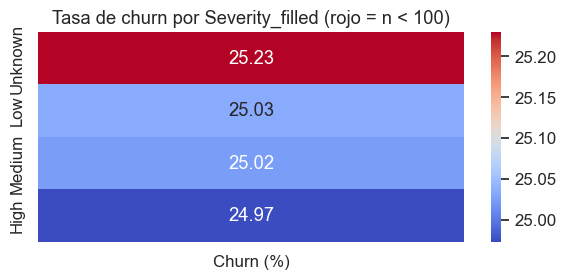

Guardado: fig/heatmap_churn_Severity_filled.png


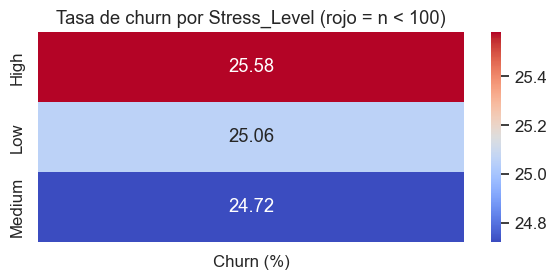

Guardado: fig/heatmap_churn_Stress_Level.png


C:\Users\acbon\AppData\Local\Temp\ipykernel_13752\650295376.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = df.groupby(var)["churn"].agg(n="count", churn_1="sum", rate="mean").reset_index()


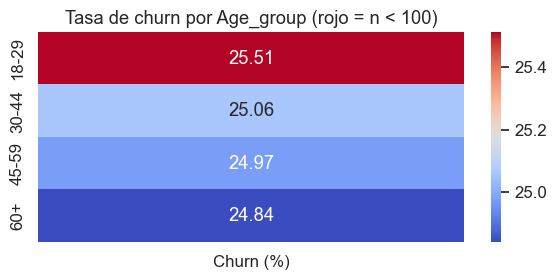

Guardado: fig/heatmap_churn_Age_group.png


In [10]:
# Función para dibujar heatmap de tasa de churn
def heatmap_churn_rate(var, min_cell=100, fname=None):
    """
    Dibuja heatmap de tasa de churn por categoría de var.
    Enmascara categorías con n < min_cell.
    """
    # Tabla resumida (n y tasa)
    g = df.groupby(var)["churn"].agg(n="count", churn_1="sum", rate="mean").reset_index()
    g["rate_pct"] = 100 * g["rate"]
    g["mask"] = g["n"] < min_cell

    # Orden por tasa
    g = g.sort_values("rate_pct", ascending=False)

    # Heatmap 1D (categorías en eje Y)
    plt.figure(figsize=(6, max(3, 0.35*len(g))))
    # Creamos una matriz 2D (rate) para usar heatmap fácilmente
    mat = g[["rate_pct"]].values
    ax = sns.heatmap(mat,
                     annot=g[["rate_pct"]].round(2).values,
                     fmt=".2f",
                     cmap="coolwarm",
                     cbar=True,
                     yticklabels=g[var].astype(str).tolist(),
                     xticklabels=["Churn (%)"],
                     vmin=g["rate_pct"].min(),
                     vmax=g["rate_pct"].max())
    # Enmascarado visual: cruzamos las celdas de baja frecuencia
    for i, low in enumerate(g["mask"].values):
        if low:
            ax.add_patch(plt.Rectangle((0, i), 1, 1, fill=False, edgecolor="red", linewidth=2, linestyle="--"))
    plt.title(f"Tasa de churn por {var} (rojo = n < {min_cell})")
    plt.tight_layout()
    outp = f"fig/heatmap_churn_{var}.png" if fname is None else f"fig/{fname}"
    plt.savefig(outp, dpi=150, bbox_inches="tight")
    plt.show()
    print("Guardado:", outp)

# Genera 2–3 heatmaps clave 
for var in ["Severity_filled", "Stress_Level", "Age_group"]:
    if var in cohort_vars:
        heatmap_churn_rate(var, min_cell=100, fname=f"heatmap_churn_{var}.png")

-  Las diferencias entre categorías son estadísticamente débiles (como lo mostraron los p-valores y V de Cramér).

-  Sin embargo, se perfilan patrones sutiles: abandono ligeramente mayor en jóvenes y en personas con alto estrés.

-  Estos patrones, aunque no concluyentes, pueden servir para diseñar hipótesis o subcohortes a explorar en modelos predictivos posteriores.

In [11]:
# === Guardar TODO el DataFrame preparado para Notebook 2 ===
df.to_csv("out/mental_health_data_cohortes.csv", index=False)

print(" Dataset completo guardado en: out/mental_health_data_cohortes.csv")
print(f"Dimensiones finales: {df.shape}")


 Dataset completo guardado en: out/mental_health_data_cohortes.csv
Dimensiones finales: (50000, 26)
